# ConvNet Model

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
from torch import nn,functional
import torchvision
from torchvision import datasets,transforms
device = torch.device("cuda:4" if torch.cuda.is_available else "cpu")

from sklearn.model_selection import train_test_split

%matplotlib inline

from tensorboardX import SummaryWriter


In [3]:
train_batch_size =100
validation_batch_size =100

In [4]:

#Loading data
train = pd.read_csv("./input/train.csv")
X = train.loc[:,train.columns != "label"].values/255   #Normalizing the values
Y = train.label.values

features_train, features_test, targets_train, targets_test = train_test_split(X,Y,test_size=0.2,random_state=42)
X_train = torch.from_numpy(features_train).to(device)
X_validation = torch.from_numpy(features_test).to(device)

Y_train = torch.from_numpy(targets_train).type(torch.LongTensor).to(device)
Y_validation = torch.from_numpy(targets_test).type(torch.LongTensor).to(device)

train = torch.utils.data.TensorDataset(X_train,Y_train)
validation = torch.utils.data.TensorDataset(X_validation,Y_validation)

train_loader = torch.utils.data.DataLoader(train, batch_size = train_batch_size, shuffle = False)
validation_loader = torch.utils.data.DataLoader(validation, batch_size = validation_batch_size, shuffle = False)


### ConvNet

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn_2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(32*4*4,10)         
        self.drop=nn.Dropout(p=0.3)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        
        out = self.cnn_1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        out = self.cnn_2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)

        out = out.view(out.size(0), -1)
        out = self.fc1(out)        
        out = self.drop(out)
        out = self.softmax(out)
        return out
        

In [6]:
model = CNN()
model = model.double()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.1, momentum=0.8)

In [7]:
epochs = 15
train_losses, validation_losses,validation_accs = [] ,[],[]
for epoch in range(epochs):
    running_loss = 0
    
    for images,labels in train_loader:
        train=images.view(-1,1,28,28).to(device)
        
        optimizer.zero_grad()
        
        output = model(train)
        
        with SummaryWriter(comment='CNN') as w:
            w.add_graph(model,(train))
            
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        validation_loss = 0
        accuracy = 0
        
        with torch.no_grad(): #Turning off gradients to speed up
            model.eval()
            for images,labels in validation_loader:
                
                test = images.view(-1,1,28,28).to(device)
                log_ps = model(test)
                validation_loss += criterion(log_ps,labels)
                
                #ps = torch.exp(log_ps)
                top_p, top_class = log_ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()        
        
        train_losses.append(running_loss/len(train_loader))
        validation_losses.append(validation_loss/len(validation_loader))
        validation_accs.append(accuracy/len(validation_loader))
        
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Validation Loss: {:.3f}.. ".format(validation_loss/len(validation_loader)),
              "Validation Accuracy: {:.3f}".format(accuracy/len(validation_loader)))

Epoch: 1/15..  Training Loss: 1.853..  Validation Loss: 1.522..  Validation Accuracy: 0.944
Epoch: 2/15..  Training Loss: 1.698..  Validation Loss: 1.500..  Validation Accuracy: 0.964
Epoch: 3/15..  Training Loss: 1.688..  Validation Loss: 1.492..  Validation Accuracy: 0.971
Epoch: 4/15..  Training Loss: 1.682..  Validation Loss: 1.490..  Validation Accuracy: 0.973
Epoch: 5/15..  Training Loss: 1.677..  Validation Loss: 1.487..  Validation Accuracy: 0.975
Epoch: 6/15..  Training Loss: 1.674..  Validation Loss: 1.485..  Validation Accuracy: 0.977
Epoch: 7/15..  Training Loss: 1.673..  Validation Loss: 1.485..  Validation Accuracy: 0.977
Epoch: 8/15..  Training Loss: 1.671..  Validation Loss: 1.485..  Validation Accuracy: 0.976
Epoch: 9/15..  Training Loss: 1.668..  Validation Loss: 1.483..  Validation Accuracy: 0.979
Epoch: 10/15..  Training Loss: 1.669..  Validation Loss: 1.482..  Validation Accuracy: 0.980
Epoch: 11/15..  Training Loss: 1.670..  Validation Loss: 1.480..  Validation Ac

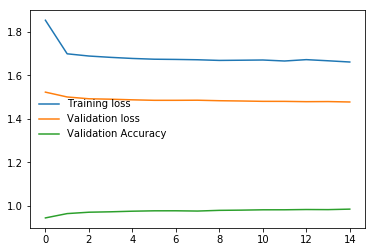

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.plot(validation_accs,label='Validation Accuracy')
plt.legend(frameon=False)

In [9]:
test_images = pd.read_csv("./input/test.csv")
test_image = test_images.loc[:,test_images.columns != "label"].values/255
test_dataset = torch.from_numpy(test_image).to(device)
new_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [10]:
top_classes = []
with torch.no_grad():
    model.eval()
    
    for images in new_test_loader:
        test = images.view(-1,1,28,28).to(device)
        output = model(test)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim = 1)
        top_classes.append(int(top_class))

In [11]:
predlabel = top_classes
predictions = np.array(predlabel)
#type(predictions)

In [12]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("./output/my_submissions_cnn.csv", index=False, header=True)